In [ ]:
pip install underthesea scikit-learn pandas numpy gensim matplotlib seaborn chardet transformers

In [20]:
import pandas as pd
import re
import chardet
import numpy as np
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [3]:
# Upload data file
from google.colab import files
uploaded = files.upload()

# Load data
data = pd.read_csv('data.csv', encoding='ISO-8859-1')

Saving data.csv to data.csv


In [11]:
def decode_text(text):
    if isinstance(text, bytes):
        encoding = chardet.detect(text)['encoding']
        decoded_text = text.decode(encoding, errors='ignore')
    else:
        decoded_text = text
    return decoded_text

In [12]:
def preprocess(text):
    # Giải mã văn bản (nếu cần)
    text = decode_text(text)

    # Loại bỏ ký tự đặc biệt
    text = re.sub(r'[^\w\s]', '', text)

    # Chuyển đổi văn bản thành chữ thường
    text = text.lower()

    # Tách từ
    words = word_tokenize(text, format="text")

    return words

# Tách dữ liệu thành features (X) và labels (y)
X = data['comment']
y = data['label']

# Chia dữ liệu thành tập huấn luyện (train) và tập kiểm tra (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tiền xử lý dữ liệu
X_train_preprocessed = [preprocess(text) for text in X_train]
X_test_preprocessed = [preprocess(text) for text in X_test]

In [14]:
# # 4. Chuyển đổi nhãn sang dạng số
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# 5. Vector hóa dữ liệu với TF-IDF, Word2Vec và Bag-of-Words
vectorizers = {}

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_preprocessed)
X_test_tfidf = tfidf_vectorizer.transform(X_test_preprocessed)
vectorizers['TF-IDF'] = tfidf_vectorizer

# Bag-of-Words
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train_preprocessed)
X_test_bow = bow_vectorizer.transform(X_test_preprocessed)
vectorizers['Bag-of-Words'] = bow_vectorizer

def create_w2v_model(data):
    w2v_model = Word2Vec(data, vector_size=100, window=5, min_count=1, workers=4)
    return w2v_model.wv

def get_w2v_vectors(data, w2v_vocab):
    return np.array([np.mean([w2v_vocab[word] for word in doc if word in w2v_vocab] or [np.zeros(100)], axis=0) for doc in data])

# Tokenize preprocessed data
tokenized_train = [doc.split() for doc in X_train_preprocessed]
tokenized_test = [doc.split() for doc in X_test_preprocessed]

# Word2Vec
w2v_vocab = create_w2v_model(tokenized_train + tokenized_test)
X_train_w2v = get_w2v_vectors(tokenized_train, w2v_vocab)
X_test_w2v = get_w2v_vectors(tokenized_test, w2v_vocab)

vectorization_methods = [
    ('TF-IDF', X_train_tfidf, X_test_tfidf),
    ('Bag-of-Words', X_train_bow, X_test_bow),
    ('Word2Vec', X_train_w2v, X_test_w2v),
    ('BERT', X_train_bert, X_test_bert)
]


# BERT
def bert_encode(data, tokenizer, max_len):
    tokens = tokenizer.batch_encode_plus(
        data,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
    )
    return {'input_ids': tokens['input_ids'], 'attention_mask': tokens['attention_mask']}

phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
phobert_model = TFAutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)

X_train_bert = bert_encode(X_train, phobert_tokenizer, max_len=128)
X_test_bert = bert_encode(X_test, phobert_tokenizer, max_len=128)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def word2vec_vectorizer(X):
    w2v_model = Word2Vec(X, vector_size=100, window=5, min_count=1, workers=4)
    w2v_vocab = set(w2v_model.wv.index_to_key)
    vectorized_data = []
    
    for doc in X:
        words = [word for word in doc if word in w2v_vocab]
        if words:
            vectorized_data.append(np.mean(w2v_model.wv[words], axis=0))
        else:
            vectorized_data.append(np.zeros(100))
    return np.array(vectorized_data)

X_train_w2v = word2vec_vectorizer(X_train)
X_test_w2v = word2vec_vectorizer(X_test)

# Định nghĩa các mô hình học máy
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('SVM', SVC()),
    ('Random Forest', RandomForestClassifier())
]

bert_model = ('BERT', phobert_model)

# Huấn luyện các mô hình với các phương pháp vector hóa khác nhau và đánh giá chúng
for vec_name, X_train_vec, X_test_vec in vectorization_methods:
    print(f"Vectorization method: {vec_name}")
    
    if vec_name != 'BERT':
        for model_name, model in models:
            model.fit(X_train_vec, y_train_encoded)
            y_pred = model.predict(X_test_vec)
            print(f"Model: {model_name}")
            print(classification_report(y_test_encoded, y_pred, target_names=encoder.classes_))
    else:
        # Huấn luyện mô hình BERT
        model_name, model = bert_model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
        model.fit(X_train_bert['input_ids'], y_train_encoded, epochs=3, batch_size=16)

        y_pred = np.argmax(model.predict(X_test_bert['input_ids']).logits, axis=1)
        print(f"Model: {model_name}")
        print(classification_report(y_test_encoded, y_pred, target_names=encoder.classes_))

Vectorization method: TF-IDF
Model: Logistic Regression
              precision    recall  f1-score   support

         NEG       0.64      0.66      0.65      1333
         NEU       0.47      0.18      0.26       978
         POS       0.81      0.93      0.86      3981

    accuracy                           0.75      6292
   macro avg       0.64      0.59      0.59      6292
weighted avg       0.72      0.75      0.72      6292

Model: SVM
              precision    recall  f1-score   support

         NEG       0.65      0.70      0.68      1333
         NEU       0.48      0.14      0.22       978
         POS       0.81      0.93      0.87      3981

    accuracy                           0.76      6292
   macro avg       0.65      0.59      0.59      6292
weighted avg       0.73      0.76      0.73      6292

Model: Random Forest
              precision    recall  f1-score   support

         NEG       0.63      0.67      0.65      1333
         NEU       0.44      0.13      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


197/197 [==============================] - 48s 244ms/step


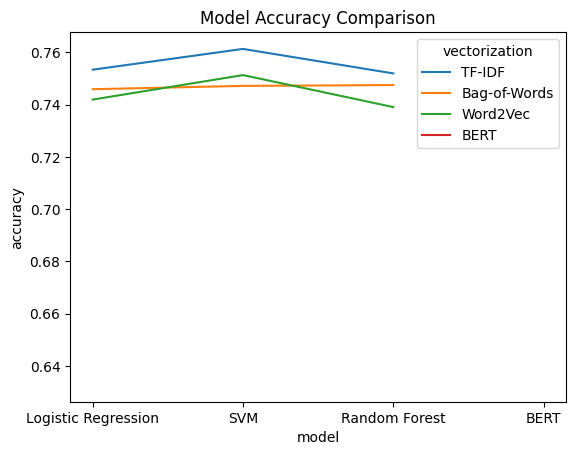

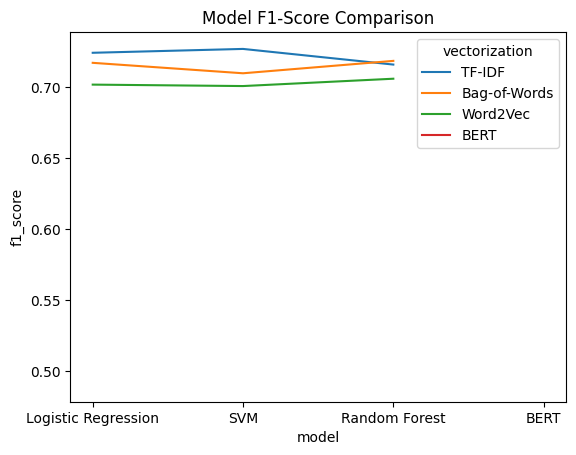

ValueError: ignored

In [21]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Lưu kết quả vào danh sách
results = []
for vec_name, X_train_vec, X_test_vec in vectorization_methods:
    if vec_name != 'BERT':
        for model_name, model in models:
            # Huấn luyện mô hình trên dữ liệu huấn luyện
            model.fit(X_train_vec, y_train_encoded)

            y_pred = model.predict(X_test_vec)
            acc = accuracy_score(y_test_encoded, y_pred)
            f1 = f1_score(y_test_encoded, y_pred, average='weighted')
            results.append((vec_name, model_name, acc, f1))
    else:
        y_pred = np.argmax(phobert_model.predict(X_test_bert['input_ids']).logits, axis=1)
        acc = accuracy_score(y_test_encoded, y_pred)
        f1 = f1_score(y_test_encoded, y_pred, average='weighted')
        results.append(('BERT', 'BERT', acc, f1))

# Vẽ biểu đồ đường so sánh các mô hình
results_df = pd.DataFrame(results, columns=['vectorization', 'model', 'accuracy', 'f1_score'])
sns.lineplot(x='model', y='accuracy', hue='vectorization', data=results_df)
plt.title('Model Accuracy Comparison')
plt.show()

sns.lineplot(x='model', y='f1_score', hue='vectorization', data=results_df)
plt.title('Model F1-Score Comparison')
plt.show()

In [ ]:
# # Vẽ ma trận nhầm lẫn cho từng mô hình
# for vec_name, X_train_vec, X_test_vec in vectorization_methods:
#     if vec_name != 'BERT':
#         for model_name, model in models:
#             y_pred = model.predict(X_test_vec)
#             cm = confusion_matrix(y_test_encoded, y_pred)
#             plot_confusion_matrix(cm, classes=encoder.classes_, title=f'{vec_name} - {model_name} Confusion Matrix')
#             plt.show()
#     else:
#         cm = confusion_matrix(y_test_encoded, y_pred)
#         plot_confusion_matrix(cm, classes=encoder.classes_, title=f'BERT Confusion Matrix')
#         plt.show()